# 5TF078 Deep Learning Course
## Project Predicting Protein-Ligand Affinity Part 1

Created by Nike Olabiyi

## Revisions:

2026-01-13 First Revision

2026-01-21 Second Revision: Comments added

## First we initilize our Python environment

In [58]:
#### Set up tests to know if we are running Colab or Kaggle
import sys
import os

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [59]:
# Import TF/Keras libraries
os.environ["KERAS_BACKEND"] = "tensorflow" # Can be "tensorflow" "jax" "pytorch"

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [60]:
# Import needed libraries
from keras.utils  import to_categorical

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# pandas
import pandas as pd

import random

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [61]:
# Test for GPU and determine what GPU we have
import platform
import subprocess
gpu_devices = tf.config.list_physical_devices('GPU')

gpu_name = tf.test.gpu_device_name()
if gpu_name != '':
    print('TF-GPU-devname:',tf.test.gpu_device_name())
    sys_details = tf.sysconfig.get_build_info()
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Num GPUs:", len(physical_devices))
    if platform.system() == "Darwin":
        print('GPU on Mac!')
    else:
        cuda_version = sys_details["cuda_version"]
        print('TF-cuda version:',cuda_version)
        if len(physical_devices)>0:
            process = subprocess.Popen(['nvidia-smi','-L'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(process.communicate())
        # If possible to run code with 16 bits float instead of 32 bits float, this code activates such functionality:
        if gpu_devices:
            details = tf.config.experimental.get_device_details(gpu_devices[0])
            compute_capability=details.get('compute_capability')
            print("Compute capability:",compute_capability)
            if compute_capability[0]>6:
                print("Turning on mixed_float16")
                policy = keras.mixed_precision.Policy('mixed_float16')
                keras.mixed_precision.set_global_policy(policy)
else:
    print('TF-device CPU')

TF-GPU-devname: /device:GPU:0
Num GPUs: 1
TF-cuda version: 12.5.1
(b'GPU 0: Tesla T4 (UUID: GPU-69c79f0b-0b4b-7905-0e08-51cb220d8105)\n', b'')
Compute capability: (7, 5)
Turning on mixed_float16


## Set up the needed data sets

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
os.getcwd()

'/content'

In [11]:
base_path = "/content/drive/MyDrive/XXX" # Change this to the path where you have stored the data on your Google Drive
os.listdir(base_path)

['sampleSubmission_taskn.csv',
 'test_task3_screening.csv',
 'test_task2_transfer.csv',
 'test_task1.csv',
 'train.csv',
 'saved_models']

In [12]:
train_path = base_path + "train.csv"
df_train = pd.read_csv(train_path)

print(df_train.columns)
print(df_train.shape)
df_train.head(10)

Index(['protein_sequence', 'compound_smiles', 'label'], dtype='object')
(263583, 3)


,protein_sequence,compound_smiles,label
0,MAALRQPQVAELLAEARRAFREEFGAEPELAVSAPGRVNLIGEHTD...,C1CC2=C(C(=O)C1)C3(CCS(=O)(=O)C3)N=C(N2)NC4=NC...,5.175425
1,MAVMKNYLLPILVLFLAYYYYSTNEEFRPEMLQGKKVIVTGASKGI...,C1CC1(C2=CC=C(C=C2)F)C(=O)N3CC4CC4(C3)C5=CNC6=...,6.173925
2,MKKYLLPVLVLCLGYYYSTNEEFRPEMLQGKKVIVTGASKGIGREM...,C1CC1(C2=CC=C(C=C2)F)C(=O)N3CC4CC4(C3)C5=CNC6=...,6.031517
3,MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...,CNC(=O)C1=CC2=C(C=C1)C3CCCN(C3C2)C(=O)C4=CC5=C...,6.147520
4,MAPPSEETPLIPQRSCSLLSTEAGALHVLLPARGPGPPQRLSFSFG...,CC(C)(C)OC(=O)N1CCC2=C(CC1)C=C(C=C2)NC3=NN4C=C...,6.644166
5,MAPPSEETPLIPQRSCSLLSTEAGALHVLLPARGPGPPQRLSFSFG...,CS(=O)(=O)C1=CC=C(C=C1)C(=C)N2C(=NC(=N2)NC(=O)...,5.000043
6,MADPAAGPPPSEGEESTVRFARKGALRQKNVHEVKNHKFTARFFKQ...,CC12C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8...,6.327902
7,MADPAAGPPPSEGEESTVRFARKGALRQKNVHEVKNHKFTARFFKQ...,C1=CC=C2C(=C1)C(=CN2)C3=C(C(=O)NC3=O)C4=CNC5=C...,6.259637
8,MADPAAGPPPSEGEESTVRFARKGALRQKNVHEVKNHKFTARFFKQ...,C1C(=C(C(=O)N1)C2=CNC3=CC=CC=C32)C4=CNC5=CC=CC...,4.987163
9,MADPAAGPPPSEGEESTVRFARKGALRQKNVHEVKNHKFTARFFKQ...,C1=CC=C2C(=C1)C(=CN2)C3=C(C(=O)NC3O)C4=CNC5=CC...,4.292430


### Test sets

In [13]:
# Load test sets - UPDATE WITH YOUR ACTUAL PATHS
print("Loading test datasets...")
test1_df = pd.read_csv(base_path + '/test_task1.csv')
test2_df = pd.read_csv(base_path + '/test_task2_transfer.csv')
test3_df = pd.read_csv(base_path + '/test_task3_screening.csv')

print(f"Test Set 1: {len(test1_df):,} samples")
print(f"Test Set 2: {len(test2_df):,} samples")
print(f"Test Set 3: {len(test3_df):,} samples")

# Check column names consistency
print("\nColumn names check:")
print("Train columns:", df_train.columns.tolist())
print("Test1 columns:", test1_df.columns.tolist())
print("Test2 columns:", test2_df.columns.tolist())
print("Test3 columns:", test3_df.columns.tolist())

Loading test datasets...
Test Set 1: 113,168 samples
Test Set 2: 60,238 samples
Test Set 3: 17 samples

Column names check:
Train columns: ['protein_sequence', 'compound_smiles', 'label']
Test1 columns: ['protein_sequence', 'compound_smiles']
Test2 columns: ['protein_sequence', 'compound_smiles']
Test3 columns: ['protein_sequence', 'compound_smiles']


## Check the sets and see if anything is missing or faulty

In [14]:
def check_set(df_set_name):
    df = df_set_name
    # 1) Missing values
    print(df.isna().sum())

    # 2) Empty strings
    empty_prot = (df["protein_sequence"].astype(str).str.len() == 0).sum()
    empty_smi  = (df["compound_smiles"].astype(str).str.len() == 0).sum()
    print("Empty protein sequences:", empty_prot)
    print("Empty SMILES:", empty_smi)

    # 3) Basic label sanity (only if label column exists)
    if "label" in df.columns:
        n_total = len(df)

        n_nan = df["label"].isna().sum()
        n_empty_str = (
            df["label"]
            .astype(str)
            .str.strip()
            .eq("")
            .sum()
        )

        print("Label sanity check:")
        print(f"  Total rows      : {n_total}")
        print(f"  NaN labels      : {n_nan}")
        print(f"  Empty labels    : {n_empty_str}")
        print(f"  Valid labels    : {n_total - n_nan - n_empty_str}")

        print("\nLabel statistics (non-NaN only):")
        print(df.loc[~df["label"].isna(), "label"].describe())

    else:
        print("No labels found (this is a test set)")

    # 4) Duplicates
    print("Duplicate rows:", df.duplicated(subset=["protein_sequence","compound_smiles"]).sum())

    # 5) Length distributions => need to see if any protein is shorter than 50 AAs
    df["prot_len"] = df["protein_sequence"].str.len()
    df["smi_len"]  = df["compound_smiles"].str.len()
    print("Sequence length statistics:")
    if "label" in df.columns:
      df["pIC50"]  = df["label"].astype(float)
      print(df[["pIC50"]].describe(percentiles=[.5,.75,.9,.95,.99]))
    print(df[["prot_len","smi_len"]].describe(percentiles=[.5,.75,.9,.95,.99]))

In [15]:
# Check test set 1
print(f"\n{'='*50}")
print(f"CHECKING TEST SET 1")
print(f"{'='*50}")
check_set(test1_df)


CHECKING TEST SET 1
protein_sequence    0
compound_smiles     0
dtype: int64
Empty protein sequences: 0
Empty SMILES: 0
No labels found (this is a test set)
Duplicate rows: 1451
Sequence length statistics:
            prot_len        smi_len
count  113168.000000  113168.000000
mean      581.721980      56.958619
std       273.662078      14.947578
min        66.000000       7.000000
50%       503.000000      57.000000
75%       706.000000      67.000000
90%      1040.000000      76.000000
95%      1199.000000      83.000000
99%      1382.000000      94.000000
max      1484.000000     100.000000


In [16]:
# Check test set 2
print(f"\n{'='*50}")
print(f"CHECKING TEST SET 2")
print(f"{'='*50}")
check_set(test2_df)


CHECKING TEST SET 2
protein_sequence    0
compound_smiles     0
dtype: int64
Empty protein sequences: 0
Empty SMILES: 0
No labels found (this is a test set)
Duplicate rows: 2618
Sequence length statistics:
           prot_len       smi_len
count  60238.000000  60238.000000
mean     433.979465     62.213188
std      173.365384     14.342104
min       59.000000      7.000000
50%      395.000000     62.000000
75%      444.000000     72.000000
90%      482.000000     81.000000
95%      787.000000     86.000000
99%     1212.000000     95.000000
max     1212.000000    100.000000


In [17]:
# Check test set 3
print(f"\n{'='*50}")
print(f"CHECKING TEST SET 3")
print(f"{'='*50}")
check_set(test3_df)


CHECKING TEST SET 3
protein_sequence    0
compound_smiles     0
dtype: int64
Empty protein sequences: 0
Empty SMILES: 0
No labels found (this is a test set)
Duplicate rows: 0
Sequence length statistics:
       prot_len    smi_len
count      17.0  17.000000
mean      304.0  64.941176
std         0.0   3.864431
min       304.0  59.000000
50%       304.0  65.000000
75%       304.0  67.000000
90%       304.0  70.400000
95%       304.0  71.200000
99%       304.0  71.840000
max       304.0  72.000000


### Test training set

In [18]:
# Check training set
print(f"\n{'='*50}")
print(f"CHECKING TRAINING SET")
print(f"{'='*50}")
check_set(df_train)


CHECKING TRAINING SET
protein_sequence    0
compound_smiles     0
label               0
dtype: int64
Empty protein sequences: 0
Empty SMILES: 0
Label sanity check:
  Total rows      : 263583
  NaN labels      : 0
  Empty labels    : 0
  Valid labels    : 263583

Label statistics (non-NaN only):
count    263583.000000
mean          6.339674
std           1.475182
min           2.000000
25%           5.221849
50%           6.301030
75%           7.443697
max          11.000000
Name: label, dtype: float64
Duplicate rows: 7287
Sequence length statistics:
               pIC50
count  263583.000000
mean        6.339674
std         1.475182
min         2.000000
50%         6.301030
75%         7.443697
90%         8.301030
95%         8.698970
99%         9.522879
max        11.000000
            prot_len        smi_len
count  263583.000000  263583.000000
mean      582.747237      56.888498
std       274.457262      14.930039
min        66.000000       2.000000
50%       503.000000      57.00

### Fix dublicates in train set

In [19]:
dup_pairs = df_train.duplicated(subset=["protein_sequence","compound_smiles"], keep=False).sum()
print("Rows that belong to duplicated pairs:", dup_pairs)

n_dup_groups = df_train.groupby(["protein_sequence","compound_smiles"]).size().gt(1).sum()
print("Number of duplicated (protein,smiles) pairs:", n_dup_groups)

Rows that belong to duplicated pairs: 13583
Number of duplicated (protein,smiles) pairs: 6296


In [20]:
df_unique = (
    df_train.groupby(["protein_sequence", "compound_smiles"], as_index=False)
      ["label"].mean()
)

print("Before:", df_train.shape)
print("After :", df_unique.shape)

Before: (263583, 6)
After : (256296, 3)


In [21]:
df_unique.head(10)

,protein_sequence,compound_smiles,label
0,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)C(F)(F)F)CN(CC(C(F)(F)F)O)C2=CC(...,4.397940
1,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)C(F)(F)F)CN(CC(C(F)(F)F)O)C2=CC=...,5.000000
2,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)F)N(CC2=CC=C(C=C2)OC(F)(F)F)CC(C...,4.823909
3,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,7.522879
4,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,7.000000
5,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,7.000000
6,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,7.096910
7,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,7.000000
8,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,6.522879
9,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,5.455932


In [22]:
print("Duplicate rows:", df_unique.duplicated(subset=["protein_sequence","compound_smiles"]).sum())

Duplicate rows: 0


In [23]:
print(df_unique["label"].min())
df_unique["label"].max()

2.0


11.0

## Define constants for the model

In [24]:
# 1) No truncation (use max length)
MAX_PROT_LEN_FULL = 1484      # 100% of proteins kept, shorter proteins sequences will be truncated

# 2) Minimal truncation (~1%)
MAX_PROT_LEN_P99  = 1388      # 99th percentile, everything above - truncated

# 3) Moderate truncation (~5%)
MAX_PROT_LEN_P95  = 1203      # 95th percentile

# SMILES length (keep max)
MAX_SMI_LEN = 100

## Split the data

The test sets do not contain lablels. I need to split the current set into train, test and val.

In [25]:
from sklearn.model_selection import train_test_split

# First split: separate test set (80% train+val, 20% test)
train_val_df, test_df = train_test_split(
    df_unique, test_size=0.2, random_state=42
)

# Second split: separate train and validation (80% train, 20% val of remaining)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.25, random_state=42  # 0.25 of 0.8 = 0.2 of total
)

print(f"Train set: {len(train_df):,} samples ({len(train_df)/len(df_unique)*100:.1f}%)")
print(f"Validation set: {len(val_df):,} samples ({len(val_df)/len(df_unique)*100:.1f}%)")
print(f"Test set: {len(test_df):,} samples ({len(test_df)/len(df_unique)*100:.1f}%)")

Train set: 153,777 samples (60.0%)
Validation set: 51,259 samples (20.0%)
Test set: 51,260 samples (20.0%)


## Let's tokenize the data

In [26]:
from tensorflow.keras.layers import TextVectorization

prot_vec = TextVectorization(
    standardize=None,
    split="character",
    output_mode="int",
    output_sequence_length=MAX_PROT_LEN_P99,
)

smi_vec = TextVectorization(
    standardize=None,
    split="character",
    output_mode="int",
    output_sequence_length=MAX_SMI_LEN,
)

# Fit vectorizers on TRAINING data only
prot_vec.adapt(train_df["protein_sequence"].values)
smi_vec.adapt(train_df["compound_smiles"].values)

## Let's vectorize to tensors

In [27]:
# Apply tokenization to BOTH sets
# train set
X_prot_train = prot_vec(train_df["protein_sequence"].values) # Tokenize training data
X_smi_train  = smi_vec(train_df["compound_smiles"].values) # Tokenize training data
y_train      = train_df["label"].astype("float32").values

# Val set
X_prot_val = prot_vec(val_df["protein_sequence"].values) # Tokenize validation data
X_smi_val  = smi_vec(val_df["compound_smiles"].values) # Tokenize validation data
y_val      = val_df["label"].astype("float32").values

# test set
X_prot_test = prot_vec(test_df["protein_sequence"].values) # Tokenize test data
X_smi_test  = smi_vec(test_df["compound_smiles"].values) # Tokenize test data
y_test      = test_df["label"].astype("float32").values

In [28]:
print(X_prot_train.shape, X_smi_train.shape, y_train.shape, X_prot_test.shape)

(153777, 1388) (153777, 100) (153777,) (51260, 1388)


## Define model training parameters

In [29]:
# Early Stopping Callback
from tensorflow.keras.callbacks import EarlyStopping

# Create early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Learning Rate Scheduler Callback (for large DataSets)
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # Reduce LR by half
    patience=5,        # Wait 5 epochs before reducing
    min_lr=1e-6,       # Don't go below this
    verbose=1
)

# Add to callbacks
callbacks = [early_stopping, lr_scheduler]

## Functions

### Plotting Train and Val MAE and LOSS

In [30]:
def plot_train_val_metrics():
    epochrange = range(1, len(history.history['loss']) + 1)

    # MAE metrics
    train_mae = history.history['mae']
    val_mae = history.history['val_mae']

    # MSE loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create subplots
    plt.figure(figsize=(12, 4))

    # MAE plot
    plt.subplot(1, 2, 1)
    plt.plot(epochrange, train_mae, 'bo-', label='Training MAE')
    plt.plot(epochrange, val_mae, 'ro-', label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochrange, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochrange, val_loss, 'ro-', label='Validation Loss')
    plt.title('Mean Squared Error Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Train the model

In [31]:
import time

def train_the_model():
  # Record start time
  start_time = time.time()
  print(f"Start Time:: {time.strftime('%H:%M:%S')}")

  # Train with LR scheduling
  history = model.fit(
      x=[X_prot_train, X_smi_train],
      y=y_train,
      batch_size=batch_size,
      epochs=number_of_epochs,
      validation_data=([X_prot_val, X_smi_val], y_val),
      callbacks=callbacks,
      verbose=1
  )

  # Record end time and calculate duration
  end_time = time.time()
  training_duration = end_time - start_time

  # Print training summary
  print("="*20)
  print("TRAINING COMPLETED!")
  print(f"End Time:: {time.strftime('%H:%M:%S')}")
  print(f"Total training time: {training_duration/3600:.2f} hours ({training_duration:.1f} seconds)")
  print("="*20)

  print(f"Epochs Completed: {len(history.history['loss'])}")
  print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
  print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
  print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")
  print("="*20)

  return history

### Evalute Test Set

In [32]:
# Evaluate DeepDTA model on test set
def evaluate_test_set():
  print("="*50)
  print("EVALUATING the MODEL ON TEST SET")
  print("="*50)

  # Evaluate on your internal test set (20% of original data)
  test_loss, test_mae = model.evaluate([X_prot_test, X_smi_test], y_test, verbose=0)
  print(f"Test Set - Loss (MSE): {test_loss:.4f}, MAE: {test_mae:.4f}")

  # Compare to literature benchmarks
  print(f"\nBenchmark comparison:")
  print(f"My model MSE:     {test_loss:.4f}")
  print(f"DeepDTA paper MSE:  ~0.26 (approximate)")

  return test_loss, test_mae

### Plot predictions

In [33]:
def plot_predictions():
  """
  Create prediction plot for test set evaluation
  """
  import matplotlib.pyplot as plt
  from sklearn.metrics import r2_score

  # Generate predictions for test set
  pred_test = model.predict([X_prot_test, X_smi_test], verbose=0).flatten()

  # Simple scatter plot
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test, pred_test, alpha=0.6)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2)
  plt.xlabel('Actual Affinity')
  plt.ylabel('Predicted Affinity')
  #plt.title(f'DeetSTA model Predictions vs Actual (Test Set)\nR² = {r2_score(y_test, pred_test):.3f}')
  plt.title(f'My model Predictions vs Actual (Test Set)\nR² = {r2_score(y_test, pred_test):.3f}')
  plt.grid(True, alpha=0.3)
  plt.show()

### Print Preformance summary

In [34]:
# Performance Summary
def print_performance_summary():
  print("\n" + "="*50)
  print("PERFORMANCE SUMMARY")
  print("="*50)

  # --- MAE ---
  print(f"Training MAE:        {history.history['mae'][-1]:.4f}")
  print(f"Validation MAE:      {min(history.history['val_mae']):.4f}")
  print(f"Test MAE:            {test_mae:.4f}")
  print(f"Validation-Test Gap: {abs(min(history.history['val_mae']) - test_mae):.4f}")

  # --- MSE ---
  print("="*50)
  print(f"Training MSE:        {history.history['loss'][-1]:.4f}")
  print(f"Validation MSE:      {min(history.history['val_loss']):.4f}")
  print(f"Test MSE:            {test_loss:.4f}")
  print(f"Validation-Test Gap: {abs(min(history.history['val_loss']) - test_loss):.4f}")

  print("="*50)

## Define input and output dimensions

In [35]:
# Protein
input_dim_prot = len(prot_vec.get_vocabulary()) # vocabulary size
output_dim = 128 #  taken from DeepDTA paper

# SMILES
input_dim_smi  = len(smi_vec.get_vocabulary())

# Model 1 DeepDTA Architecture

The model arcitecture is taken from DeepDTA: https://github.com/hkmztrk/DeepDTA

https://academic.oup.com/bioinformatics/article/34/17/i821/5093245

In [ ]:
def build_combined_cnn_model():

    # PROTEIN BRANCH
    # Input layer
    protein_input = keras.Input(shape=(MAX_PROT_LEN_P99,), name="protein_input")

    # Embedding layer
    protein_embedding = keras.layers.Embedding(
        input_dim=input_dim_prot,
        output_dim=output_dim,
        input_length=MAX_PROT_LEN_P99,
        mask_zero=True,
        name="protein_embedding"
    )(protein_input)

    # First Conv1D:
    protein_conv1 = keras.layers.Conv1D(
        filters=32,          # Starting with 32 filters
        kernel_size=8,       # Window size of 8 amino acids
        activation='relu',
        padding='valid',     # No padding (reduces sequence length) - used in the paper
        name="protein_conv1"
    )(protein_embedding)     # Apply to embedding output

    # Second Conv1D:
    protein_conv2 = keras.layers.Conv1D(
        filters=64,          # 32 * 2 filters
        kernel_size=8,
        activation='relu',
        padding='valid',
        name="protein_conv2"
    )(protein_conv1)         # Apply to first conv output

    # Third Conv1D:
    protein_conv3 = keras.layers.Conv1D(
        filters=96,          # 32 * 3 filters
        kernel_size=8,
        activation='relu',
        padding='valid',
        name="protein_conv3"
    )(protein_conv2)         # Apply to second conv output

    protein_features = keras.layers.GlobalMaxPooling1D(
        name="protein_pooling"
        )(protein_conv3)         # Reduces to fixed-size vector


    # Ligang SMILES BRANCH
    smiles_input = keras.Input(shape=(MAX_SMI_LEN,), name="smiles_input")

    # SMILES Embedding Layer
    smiles_embedding = keras.layers.Embedding(
        input_dim=input_dim_smi,      # SMILES vocabulary size
        output_dim=output_dim,        # Same as protein (128)
        input_length=MAX_SMI_LEN,     # SMILES max length
        mask_zero=True,               # Handle padding
        name="smiles_embedding"
    )(smiles_input)                   # Apply to SMILES input

    # SMILES First Conv1D Layer
    smiles_conv1 = keras.layers.Conv1D(
        filters=32,
        kernel_size=4,        # Smaller kernel for SMILES
        activation='relu',
        padding='valid',
        name="smiles_conv1"
    )(smiles_embedding)

    # Second Conv1D
    smiles_conv2 = keras.layers.Conv1D(
        filters=64,           # 32 * 2
        kernel_size=4,
        activation='relu',
        padding='valid',
        name="smiles_conv2"
    )(smiles_conv1)

    # Third Conv1D
    smiles_conv3 = keras.layers.Conv1D(
        filters=96,           # 32 * 3
        kernel_size=4,
        activation='relu',
        padding='valid',
        name="smiles_conv3"
    )(smiles_conv2)

    # SMILES Global Max Pooling
    smiles_features = keras.layers.GlobalMaxPooling1D(
        name="smiles_pooling"
    )(smiles_conv3)


    # Combine protein and SMILES features
    combined_features = keras.layers.Concatenate(
        name="feature_concatenation"
    )([protein_features, smiles_features])

    # Add Dense (Fully Connected) Layers
    # First dense layer
    dense1 = keras.layers.Dense(
        1024,
        activation='relu',
        name="dense1"
    )(combined_features)

    # Dropout for regularization
    dropout1 = keras.layers.Dropout(0.1, name="dropout1")(dense1)

    # Second dense layer
    dense2 = keras.layers.Dense(
        1024,
        activation='relu',
        name="dense2"
    )(dropout1)

    # Second dropout
    dropout2 = keras.layers.Dropout(0.1, name="dropout2")(dense2)

    # Third dense layer
    dense3 = keras.layers.Dense(
        512,
        activation='relu',
        name="dense3"
    )(dropout2)

    # Final output layer
    output = keras.layers.Dense(
        1,
        name="affinity_prediction"
    )(dense3)

    # CREATE THE MODEL
    model = keras.Model(
        inputs=[protein_input, smiles_input],
        outputs=output,
        name="DeepDTA_Model"
    )

    # RETURN THE MODEL
    return model

## Let's compile the model

In [ ]:
model = build_combined_cnn_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'protein_conv1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'smiles_conv1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "DeepDTA_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ protein_input       │ (None, 1388)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_embedding   │ (None, 1388, 128) │      2,944 │ protein_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_embedding    │ (None, 100, 128)  │      6,400 │ smiles_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_conv1       │ (None, 1381, 32)  │     32,800 │ protein_embeddin… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_conv1        │ (None, 97, 32)    │     16,416 │ smiles_embedding… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_conv2       │ (None, 1374, 64)  │     16,448 │ protein_conv1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_conv2        │ (None, 94, 64)    │      8,256 │ smiles_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_conv3       │ (None, 1367, 96)  │     49,248 │ protein_conv2[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_conv3        │ (None, 91, 96)    │     24,672 │ smiles_conv2[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_pooling     │ (None, 96)        │          0 │ protein_conv3[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_pooling      │ (None, 96)        │          0 │ smiles_conv3[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concatenat… │ (None, 192)       │          0 │ protein_pooling[… │
│ (Concatenate)       │                   │            │ smiles_pooling[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 1024)      │    197,632 │ feature_concaten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 1024)      │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 1024)      │  1,049,600 │ dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout2 (Dropout)  │ (None, 1024)      │          0 │ dense2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense3 (Dense)      │ (None, 512)       │    524,800 │ dropout2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,929,729 (7.36 MB)

 Trainable params: 1,929,729 (7.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 64
number_of_epochs = 100

In [ ]:
model.compile(
    optimizer='adam',
    loss='mse',          # Mean Squared Error for regression
    metrics=['mae']      # Mean Absolute Error for monitoring
)

## Train the model

In [ ]:
history = train_the_model()

Start Time:: 19:16:34
Epoch 1/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 1.3813 - mae: 0.9256 - val_loss: 1.3918 - val_mae: 0.9288 - learning_rate: 0.0010
Epoch 2/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 1.2784 - mae: 0.8873 - val_loss: 1.4304 - val_mae: 0.9457 - learning_rate: 0.0010
Epoch 3/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - loss: 1.2083 - mae: 0.8591 - val_loss: 1.4751 - val_mae: 0.9617 - learning_rate: 0.0010
Epoch 4/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 1.1454 - mae: 0.8342 - val_loss: 1.3090 - val_mae: 0.9011 - learning_rate: 0.0010
Epoch 5/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - loss: 1.0820 - mae: 0.8100 - val_loss: 1.1739 - val_mae: 0.8476 - learning_rate: 0.0010
Epoch 6/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - loss: 1.0217 - mae: 0.7851 - val_loss: 1.0587 - val_mae: 0.7990 - learning_rate: 0.0010
Epoch 7/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - loss: 0.9707 - mae: 0.7648 - val_loss

### Save the model

In [ ]:
# Save the trained model
print("Saving model...")
model.save(base_path + '/deepdta_model.keras')
print("Model saved successfully!")

Saving model...
Model saved successfully!


In [ ]:
model.save_weights(base_path + '/deepdta_weights.weights.h5')
print("Weights saved successfully!")

Weights saved successfully!


In [ ]:
# Save training history
import pickle
with open(base_path + '/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## Plot train and Val metrics

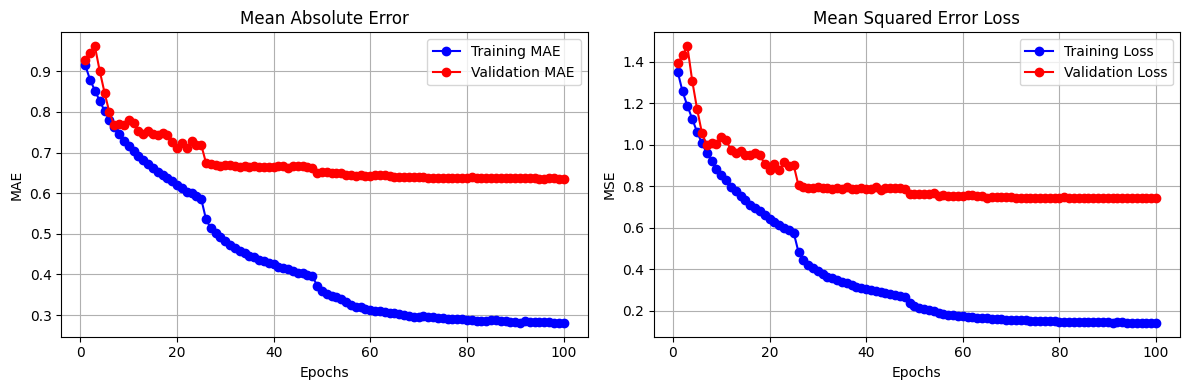

In [ ]:
plot_train_val_metrics()

In [88]:
# Load saved model and training history
import keras
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Load the model and history
model = keras.models.load_model(base_path + '/deepdta_model.keras')
with open(base_path + '/training_history.pkl', 'rb') as f:
    history_dict = pickle.load(f)

class MockHistory:
    def __init__(self, history_dict):
        self.history = history_dict

history = MockHistory(history_dict)
print("Model and history loaded successfully!")

Model and history loaded successfully!


## Evaluate test set

In [46]:
test_loss, test_mae = evaluate_test_set()


EVALUATING the MODEL ON TEST SET
Test Set - Loss (MSE): 0.7336, MAE: 0.6316

Benchmark comparison:
My model MSE:     0.7336
DeepDTA paper MSE:  ~0.26 (approximate)


## Plot predictions

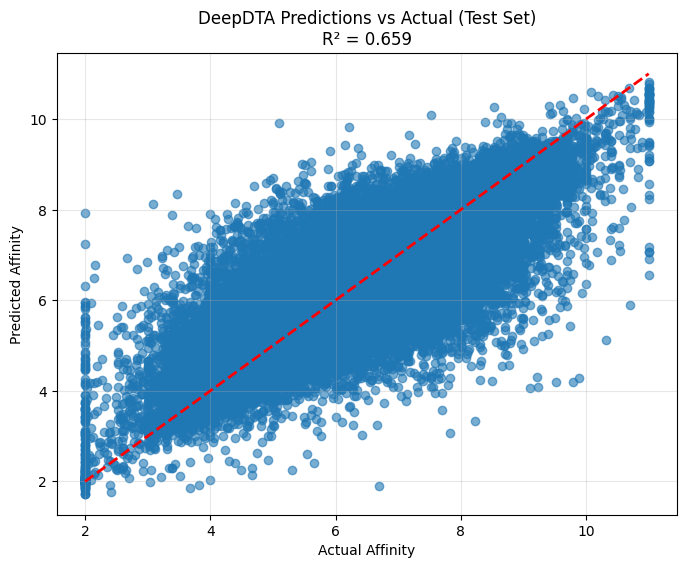

In [ ]:
plot_predictions()

## Print summary

In [49]:
print_performance_summary()


PERFORMANCE SUMMARY
Training MAE:        0.2810
Validation MAE:      0.6359
Test MAE:            0.6316
Validation-Test Gap: 0.0043
Training MSE:        0.1426
Validation MSE:      0.7421
Test MSE:            0.7336
Validation-Test Gap: 0.0085


The model is overfitting the training set. Adjustments must be made to fix this issue. Try to simplify the model.

# Model 2 Adjusted DeetDTA CNN

**Increase dropOut for Dense Layeras to 0.3**

dropout1 = keras.layers.Dropout(0.3, name="dropout1")(dense1)  # was 0.1

dropout2 = keras.layers.Dropout(0.3, name="dropout2")(dense2)  # was 0.1

**and Smaller dense layers**

dense1 = keras.layers.Dense(512, activation='relu')(combined_features)  # was 1024

dense2 = keras.layers.Dense(256, activation='relu')(dropout1)           # was 1024

dense3 = keras.layers.Dense(128, activation='relu')(dropout2)           # was 512

In [ ]:
drop_out_1 = 0.3
drop_out_2 = 0.3

dense1_nodes = 512
dense2_nodes = 256
dense3_nodes = 128

In [ ]:
# Protein
input_dim_prot = len(prot_vec.get_vocabulary()) # vocabulary size
output_dim = 128 #  taken from DeepDTA paper

# SMILES
input_dim_smi  = len(smi_vec.get_vocabulary())

## Build the new model

In [ ]:
def build_combined_cnn_model():

    # PROTEIN BRANCH
    # Input layer
    protein_input = keras.Input(shape=(MAX_PROT_LEN_P99,), name="protein_input")

    # Embedding layer
    protein_embedding = keras.layers.Embedding(
        input_dim=input_dim_prot,
        output_dim=output_dim,
        input_length=MAX_PROT_LEN_P99,
        mask_zero=True,
        name="protein_embedding"
    )(protein_input)

    # First Conv1D:
    protein_conv1 = keras.layers.Conv1D(
        filters=32,          # Starting with 32 filters
        kernel_size=8,       # Window size of 8 amino acids
        activation='relu',
        padding='valid',     # No padding (reduces sequence length) - used in the paper
        name="protein_conv1"
    )(protein_embedding)     # Apply to embedding output

    # Second Conv1D:
    protein_conv2 = keras.layers.Conv1D(
        filters=64,          # 32 * 2 filters
        kernel_size=8,
        activation='relu',
        padding='valid',
        name="protein_conv2"
    )(protein_conv1)         # Apply to first conv output

    # Third Conv1D:
    protein_conv3 = keras.layers.Conv1D(
        filters=96,          # 32 * 3 filters
        kernel_size=8,
        activation='relu',
        padding='valid',
        name="protein_conv3"
    )(protein_conv2)         # Apply to second conv output

    protein_features = keras.layers.GlobalMaxPooling1D(
        name="protein_pooling"
        )(protein_conv3)         # Reduces to fixed-size vector


    # Ligang SMILES BRANCH
    smiles_input = keras.Input(shape=(MAX_SMI_LEN,), name="smiles_input")

    # SMILES Embedding Layer
    smiles_embedding = keras.layers.Embedding(
        input_dim=input_dim_smi,      # SMILES vocabulary size
        output_dim=output_dim,               # Same as protein (128)
        input_length=MAX_SMI_LEN,     # SMILES max length
        mask_zero=True,               # Handle padding
        name="smiles_embedding"
    )(smiles_input)                   # Apply to SMILES input

    # SMILES First Conv1D Layer
    smiles_conv1 = keras.layers.Conv1D(
        filters=32,
        kernel_size=4,        # Smaller kernel for SMILES
        activation='relu',
        padding='valid',
        name="smiles_conv1"
    )(smiles_embedding)

    # Second Conv1D
    smiles_conv2 = keras.layers.Conv1D(
        filters=64,           # 32 * 2
        kernel_size=4,
        activation='relu',
        padding='valid',
        name="smiles_conv2"
    )(smiles_conv1)

    # Third Conv1D
    smiles_conv3 = keras.layers.Conv1D(
        filters=96,           # 32 * 3
        kernel_size=4,
        activation='relu',
        padding='valid',
        name="smiles_conv3"
    )(smiles_conv2)

    # SMILES Global Max Pooling
    smiles_features = keras.layers.GlobalMaxPooling1D(
        name="smiles_pooling"
    )(smiles_conv3)


    # Combine protein and SMILES features
    combined_features = keras.layers.Concatenate(
        name="feature_concatenation"
    )([protein_features, smiles_features])

    # Add Dense (Fully Connected) Layers
    # First dense layer
    dense1 = keras.layers.Dense(
        dense1_nodes,
        activation='relu',
        name="dense1"
    )(combined_features)

    # Dropout for regularization
    dropout1 = keras.layers.Dropout(drop_out_1, name="dropout1")(dense1)

    # Second dense layer
    dense2 = keras.layers.Dense(
        dense2_nodes,
        activation='relu',
        name="dense2"
    )(dropout1)

    # Second dropout
    dropout2 = keras.layers.Dropout(drop_out_2, name="dropout2")(dense2)

    # Third dense layer
    dense3 = keras.layers.Dense(
        dense3_nodes,
        activation='relu',
        name="dense3"
    )(dropout2)

    # Final output layer
    output = keras.layers.Dense(
        1,
        name="affinity_prediction"
    )(dense3)

    # CREATE THE MODEL
    model = keras.Model(
        inputs=[protein_input, smiles_input],
        outputs=output,
        name="DeepDTA_Model"
    )

    # RETURN THE MODEL
    return model

In [ ]:
model = build_combined_cnn_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'protein_conv1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'smiles_conv1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "DeepDTA_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ protein_input       │ (None, 1388)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_embedding   │ (None, 1388, 128) │      2,944 │ protein_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_embedding    │ (None, 100, 128)  │      6,400 │ smiles_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_conv1       │ (None, 1381, 32)  │     32,800 │ protein_embeddin… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_conv1        │ (None, 97, 32)    │     16,416 │ smiles_embedding… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_conv2       │ (None, 1374, 64)  │     16,448 │ protein_conv1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_conv2        │ (None, 94, 64)    │      8,256 │ smiles_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_conv3       │ (None, 1367, 96)  │     49,248 │ protein_conv2[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_conv3        │ (None, 91, 96)    │     24,672 │ smiles_conv2[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_pooling     │ (None, 96)        │          0 │ protein_conv3[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_pooling      │ (None, 96)        │          0 │ smiles_conv3[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concatenat… │ (None, 192)       │          0 │ protein_pooling[… │
│ (Concatenate)       │                   │            │ smiles_pooling[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 512)       │     98,816 │ feature_concaten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 512)       │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 256)       │    131,328 │ dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout2 (Dropout)  │ (None, 256)       │          0 │ dense2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense3 (Dense)      │ (None, 128)       │     32,896 │ dropout2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 420,353 (1.60 MB)

 Trainable params: 420,353 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [ ]:
model.compile(
    optimizer='adam',
    loss='mse',          # Mean Squared Error for regression
    metrics=['mae']      # Mean Absolute Error for monitoring
)

In [ ]:
batch_size = 64
number_of_epochs = 100

## Train the model

In [ ]:
history = train_the_model()

Start Time:: 08:00:25
Epoch 1/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 66s 22ms/step - loss: 3.1277 - mae: 1.2786 - val_loss: 1.3552 - val_mae: 0.9200 - learning_rate: 0.0010
Epoch 2/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 1.4291 - mae: 0.9426 - val_loss: 1.6698 - val_mae: 1.0209 - learning_rate: 0.0010
Epoch 3/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 1.2928 - mae: 0.8916 - val_loss: 1.2864 - val_mae: 0.8883 - learning_rate: 0.0010
Epoch 4/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 1.2144 - mae: 0.8631 - val_loss: 1.1484 - val_mae: 0.8325 - learning_rate: 0.0010
Epoch 5/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 1.1543 - mae: 0.8391 - val_loss: 1.1123 - val_mae: 0.8162 - learning_rate: 0.0010
Epoch 6/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 1.1060 - mae: 0.8206 - val_loss: 1.0879 - val_mae: 0.8100 - learning_rate: 0.0010
Epoch 7/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 1.0676 - mae: 0.8038 - val_loss

## Save the model

In [ ]:
# Save the trained model
print("Saving model...")
model.save(base_path + '/deepdta_model_2.keras')
print("Model saved successfully!")

Saving model...
Model saved successfully!


In [ ]:
model.save_weights(base_path + '/deepdta_2_weights.weights.h5')
print("Weights saved successfully!")

Weights saved successfully!


In [ ]:
# Save training history
import pickle
with open(base_path + '/training_history_2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## Plot Train & Val metrics

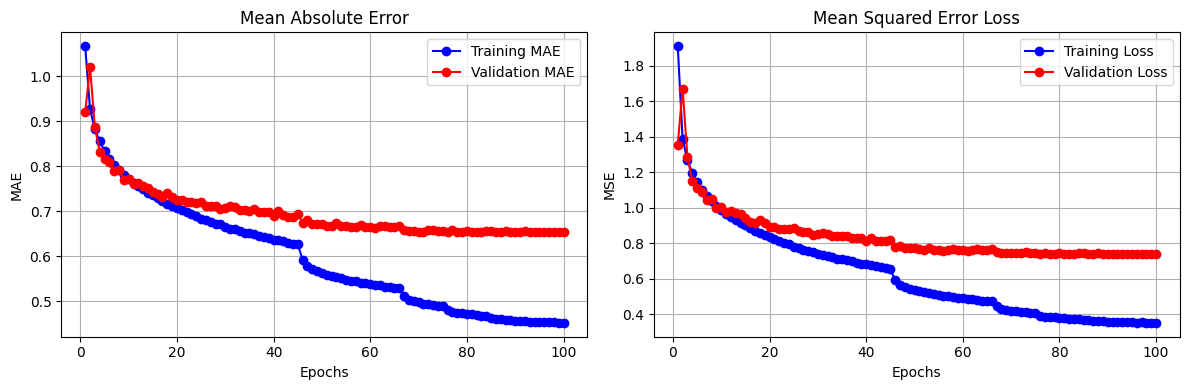

In [ ]:
plot_train_val_metrics()

## Evaluate the model on the test data

In [87]:
base_path = "/content/drive/MyDrive/DeepLearning UU/DeepLearning Project/saved_models/"
# Load saved model and training history
import keras
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Load the model and history
model = keras.models.load_model(base_path + '/deepdta_model_2.keras')
with open(base_path + '/training_history_2.pkl', 'rb') as f:
    history_dict = pickle.load(f)

class MockHistory:
    def __init__(self, history_dict):
        self.history = history_dict

history = MockHistory(history_dict)
print("Model and history loaded successfully!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'protein_conv1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'smiles_conv1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model and history loaded successfully!


In [65]:
test_loss, test_mae = evaluate_test_set()

EVALUATING the MODEL ON TEST SET
Test Set - Loss (MSE): 0.7306, MAE: 0.6501

Benchmark comparison:
My model MSE:     0.7306
DeepDTA paper MSE:  ~0.26 (approximate)


### Plot predictions

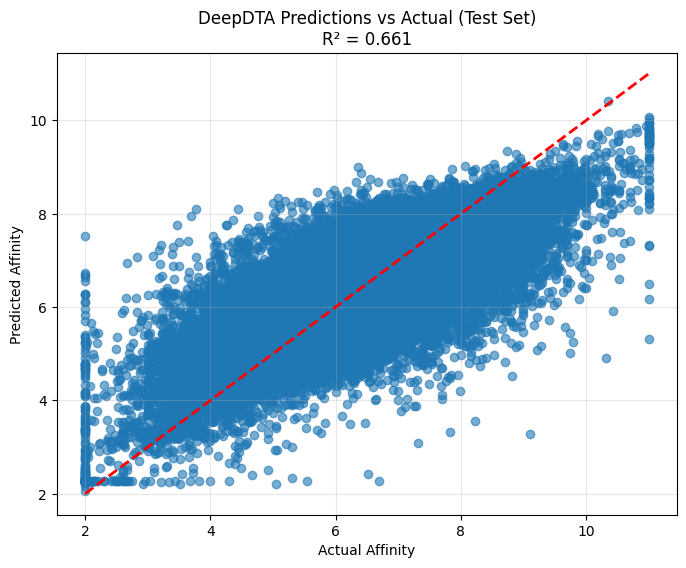

In [ ]:
plot_predictions()

### Print Summary

In [66]:
print_performance_summary()


PERFORMANCE SUMMARY
Training MAE:        0.4526
Validation MAE:      0.6532
Test MAE:            0.6501
Validation-Test Gap: 0.0031
Training MSE:        0.3510
Validation MSE:      0.7379
Test MSE:            0.7306
Validation-Test Gap: 0.0073


## Conclusions

Overfitting got less but I still would like to have better MAE for training and Val sets. I will try regularisation in Dense Layer and better Earliy_stopping policy.

# Model 3 Further Adjusted DeetDTA CNN



## Same architecture as Model 2, but with L2 on dense layers
drop_out_1 = 0.3

drop_out_2 = 0.3  

dense1_nodes = 512

dense2_nodes = 256  

dense3_nodes = 128

## Light L2 regularization - only for dense layers
l2_strength = 0.0001  # Very light regularization

In [ ]:
from keras.regularizers import l2

drop_out_1 = 0.3
drop_out_2 = 0.3

dense1_nodes = 512
dense2_nodes = 256
dense3_nodes = 128

# Light L2 regularization - only for dense layers
l2_strength = 0.0001 # Very light regularization

### Improve(?) Early stopping and LR rate policys

In [ ]:
# Early Stopping Callback
from tensorflow.keras.callbacks import EarlyStopping

# Create early stopping
early_stopping = EarlyStopping(
      monitor='val_mae',           # Monitor MAE directly
      patience=8,                  # Shorter patience (plateau at epoch 40)
      restore_best_weights=True,
      verbose=1,
      min_delta=0.001             # Only care about meaningful improvements
    )

# Learning Rate Scheduler Callback (for large DataSets)
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.7,                 # Less aggressive LR reduction
    patience=5,                 # Reduce after 5 epochs of no improvement
    min_lr=1e-6,
    verbose=1
    )

# Add to callbacks
callbacks = [early_stopping, lr_scheduler]

In [ ]:
# Protein
input_dim_prot = len(prot_vec.get_vocabulary()) # vocabulary size
output_dim = 128 #  taken from DeepDTA paper

# SMILES
input_dim_smi  = len(smi_vec.get_vocabulary())

## Build the new model

In [ ]:
def build_combined_cnn_model():

    # PROTEIN BRANCH
    # Input layer
    protein_input = keras.Input(shape=(MAX_PROT_LEN_P99,), name="protein_input")

    # Embedding layer
    protein_embedding = keras.layers.Embedding(
        input_dim=input_dim_prot,
        output_dim=output_dim,
        input_length=MAX_PROT_LEN_P99,
        mask_zero=True,
        name="protein_embedding"
    )(protein_input)

    # First Conv1D:
    protein_conv1 = keras.layers.Conv1D(
        filters=32,          # Starting with 32 filters
        kernel_size=8,       # Window size of 8 amino acids
        activation='relu',
        padding='valid',     # No padding (reduces sequence length) - used in the paper
        name="protein_conv1"
    )(protein_embedding)     # Apply to embedding output

    # Second Conv1D:
    protein_conv2 = keras.layers.Conv1D(
        filters=64,          # 32 * 2 filters
        kernel_size=8,
        activation='relu',
        padding='valid',
        name="protein_conv2"
    )(protein_conv1)         # Apply to first conv output

    # Third Conv1D:
    protein_conv3 = keras.layers.Conv1D(
        filters=96,          # 32 * 3 filters
        kernel_size=8,
        activation='relu',
        padding='valid',
        name="protein_conv3"
    )(protein_conv2)         # Apply to second conv output

    protein_features = keras.layers.GlobalMaxPooling1D(
        name="protein_pooling"
        )(protein_conv3)         # Reduces to fixed-size vector


    # Ligang SMILES BRANCH
    smiles_input = keras.Input(shape=(MAX_SMI_LEN,), name="smiles_input")

    # SMILES Embedding Layer
    smiles_embedding = keras.layers.Embedding(
        input_dim=input_dim_smi,      # SMILES vocabulary size
        output_dim=output_dim,               # Same as protein (128)
        input_length=MAX_SMI_LEN,     # SMILES max length
        mask_zero=True,               # Handle padding
        name="smiles_embedding"
    )(smiles_input)                   # Apply to SMILES input

    # SMILES First Conv1D Layer
    smiles_conv1 = keras.layers.Conv1D(
        filters=32,
        kernel_size=4,        # Smaller kernel for SMILES
        activation='relu',
        padding='valid',
        name="smiles_conv1"
    )(smiles_embedding)

    # Second Conv1D
    smiles_conv2 = keras.layers.Conv1D(
        filters=64,           # 32 * 2
        kernel_size=4,
        activation='relu',
        padding='valid',
        name="smiles_conv2"
    )(smiles_conv1)

    # Third Conv1D
    smiles_conv3 = keras.layers.Conv1D(
        filters=96,           # 32 * 3
        kernel_size=4,
        activation='relu',
        padding='valid',
        name="smiles_conv3"
    )(smiles_conv2)

    # SMILES Global Max Pooling
    smiles_features = keras.layers.GlobalMaxPooling1D(
        name="smiles_pooling"
    )(smiles_conv3)


    # Combine protein and SMILES features
    combined_features = keras.layers.Concatenate(
        name="feature_concatenation"
    )([protein_features, smiles_features])

    # Add Dense (Fully Connected) Layers
    # First dense layer
    dense1 = keras.layers.Dense(
        dense1_nodes,
        activation='relu',
        kernel_regularizer=l2(l2_strength),   # Added L2 here
        name="dense1"
    )(combined_features)

    # Dropout for regularization
    dropout1 = keras.layers.Dropout(drop_out_1, name="dropout1")(dense1)

    # Second dense layer
    dense2 = keras.layers.Dense(
        dense2_nodes,
        activation='relu',
        kernel_regularizer=l2(l2_strength),   # Added L2 here
        name="dense2"
    )(dropout1)

    # Second dropout
    dropout2 = keras.layers.Dropout(drop_out_2, name="dropout2")(dense2)

    # Third dense layer
    dense3 = keras.layers.Dense(
        dense3_nodes,
        activation='relu',
        kernel_regularizer=l2(l2_strength),   # Added L2 here
        name="dense3"
    )(dropout2)

    # Final output layer
    output = keras.layers.Dense(
        1,
        name="affinity_prediction"
    )(dense3)

    # CREATE THE MODEL
    model = keras.Model(
        inputs=[protein_input, smiles_input],
        outputs=output,
        name="DeepDTA_Model"
    )

    # RETURN THE MODEL
    return model

In [ ]:
model = build_combined_cnn_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'protein_conv1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'smiles_conv1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "DeepDTA_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ protein_input       │ (None, 1388)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_embedding   │ (None, 1388, 128) │      2,944 │ protein_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_embedding    │ (None, 100, 128)  │      6,400 │ smiles_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_conv1       │ (None, 1381, 32)  │     32,800 │ protein_embeddin… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_conv1        │ (None, 97, 32)    │     16,416 │ smiles_embedding… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_conv2       │ (None, 1374, 64)  │     16,448 │ protein_conv1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_conv2        │ (None, 94, 64)    │      8,256 │ smiles_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_conv3       │ (None, 1367, 96)  │     49,248 │ protein_conv2[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_conv3        │ (None, 91, 96)    │     24,672 │ smiles_conv2[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_pooling     │ (None, 96)        │          0 │ protein_conv3[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_pooling      │ (None, 96)        │          0 │ smiles_conv3[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concatenat… │ (None, 192)       │          0 │ protein_pooling[… │
│ (Concatenate)       │                   │            │ smiles_pooling[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 512)       │     98,816 │ feature_concaten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 512)       │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 256)       │    131,328 │ dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout2 (Dropout)  │ (None, 256)       │          0 │ dense2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense3 (Dense)      │ (None, 128)       │     32,896 │ dropout2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 420,353 (1.60 MB)

 Trainable params: 420,353 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [ ]:
model.compile(
    optimizer='adam',
    loss='mse',          # Mean Squared Error for regression
    metrics=['mae']      # Mean Absolute Error for monitoring
)

In [ ]:
batch_size = 64
number_of_epochs = 100

## Train the model

In [ ]:
history = train_the_model()

Start Time:: 10:35:34
Epoch 1/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 75s 25ms/step - loss: 2.8386 - mae: 1.2187 - val_loss: 1.6430 - val_mae: 1.0056 - learning_rate: 0.0010
Epoch 2/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - loss: 1.4427 - mae: 0.9379 - val_loss: 1.4895 - val_mae: 0.9551 - learning_rate: 0.0010
Epoch 3/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 1.3261 - mae: 0.8968 - val_loss: 1.4503 - val_mae: 0.9456 - learning_rate: 0.0010
Epoch 4/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - loss: 1.2569 - mae: 0.8721 - val_loss: 1.2364 - val_mae: 0.8660 - learning_rate: 0.0010
Epoch 5/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 1.2006 - mae: 0.8514 - val_loss: 1.1462 - val_mae: 0.8260 - learning_rate: 0.0010
Epoch 6/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 1.1579 - mae: 0.8346 - val_loss: 1.1192 - val_mae: 0.8162 - learning_rate: 0.0010
Epoch 7/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 1.1188 - mae: 0.8171 - val_loss

## Save the model

In [ ]:
# Save the trained model
print("Saving model...")
model.save(base_path + '/deepdta_model_3.keras')
print("Model saved successfully!")

Saving model...
Model saved successfully!


In [ ]:
model.save_weights(base_path + '/deepdta_3_weights.weights.h5')
print("Weights saved successfully!")

Weights saved successfully!


In [ ]:
# Save training history
import pickle
with open(base_path + '/training_history_3.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## Plot Train & Val metrics

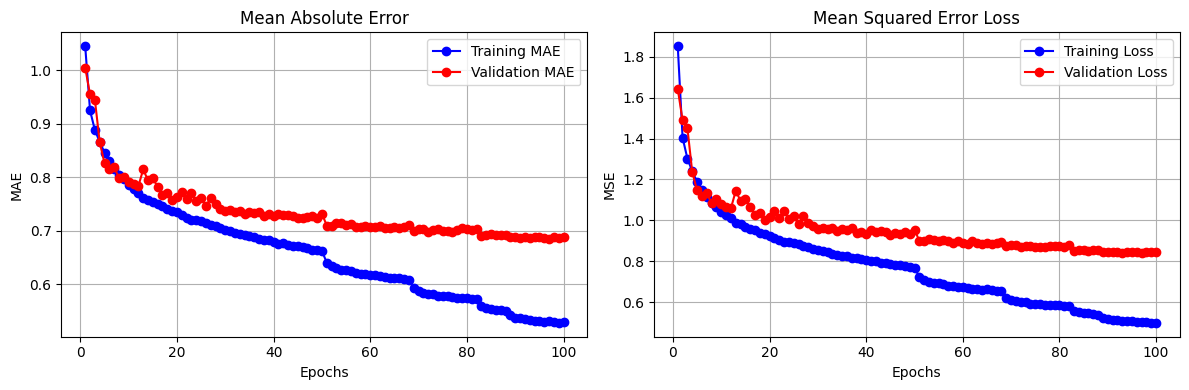

In [ ]:
plot_train_val_metrics()

## Evaluate the model on the test data

In [70]:
base_path = "/XXX" # Change this to the path where you have stored the data on your Google Drive
# Load saved model and training history
import keras
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Load the model and history
model = keras.models.load_model(base_path + '/deepdta_model_3.keras')
with open(base_path + '/training_history_3.pkl', 'rb') as f:
    history_dict = pickle.load(f)

class MockHistory:
    def __init__(self, history_dict):
        self.history = history_dict

history = MockHistory(history_dict)
print(" Model and history loaded successfully!")

 Model and history loaded successfully!


In [68]:
test_loss, test_mae = evaluate_test_set()

EVALUATING the MODEL ON TEST SET
Test Set - Loss (MSE): 0.8380, MAE: 0.6832

Benchmark comparison:
My model MSE:     0.8380
DeepDTA paper MSE:  ~0.26 (approximate)


### Plot predictions

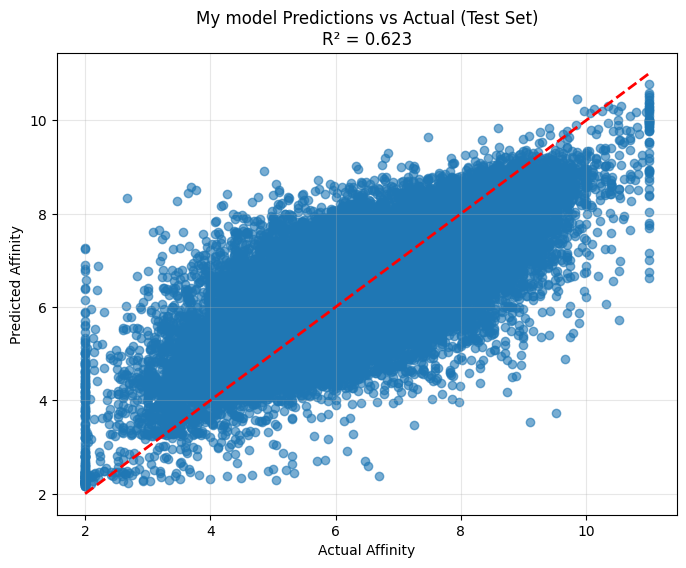

In [ ]:
plot_predictions()

### Print Summary

In [69]:
print_performance_summary()


PERFORMANCE SUMMARY
Training MAE:        0.5282
Validation MAE:      0.6844
Test MAE:            0.6832
Validation-Test Gap: 0.0011
Training MSE:        0.4989
Validation MSE:      0.8396
Test MSE:            0.8380
Validation-Test Gap: 0.0016




---



# Model 4a Hybrid CNN-LSTM, start LR 0.002

In [ ]:
drop_out_1 = 0.3
drop_out_2 = 0.3

dense1_nodes = 512
dense2_nodes = 256
dense3_nodes = 128

### Early stopping and LR rate policys (same as in Model 3)

In [ ]:
# Early Stopping Callback
from tensorflow.keras.callbacks import EarlyStopping

# Create early stopping
early_stopping = EarlyStopping(
      monitor='val_mae',           # Monitor MAE directly
      patience=8,                  # Shorter patience (plateau at epoch 40)
      restore_best_weights=True,
      verbose=1,
      min_delta=0.001             # Only care about meaningful improvements
    )

# Learning Rate Scheduler Callback (for large DataSets)
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.7,                 # Less aggressive LR reduction
    patience=5,                 # Reduce after 5 epochs of no improvement
    min_lr=1e-6,
    verbose=1
    )

# Add to callbacks
callbacks = [early_stopping, lr_scheduler]

In [ ]:
model_path = "XXX" # Change this to the path where you want to save your model on Google Drive
if not os.path.exists(model_path):
    os.makedirs(model_path)
model_path

### Saving the model due to recurring crashes

In [ ]:
# Training checkpoints - saves best model + every 10th epoch
from tensorflow.keras.callbacks import ModelCheckpoint

# Save best model (based on validation MAE)
best_checkpoint = ModelCheckpoint(
    filepath= model_path + 'best_model.keras',
    monitor='val_mae',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Save every 10th epoch
epoch_checkpoint = ModelCheckpoint(
    filepath=model_path + 'model_epoch_{epoch:02d}.keras',
    save_freq=10,  # Save every 10 epochs
    verbose=1
)

# Update callbacks
callbacks = [early_stopping, lr_scheduler, best_checkpoint, epoch_checkpoint]


In [ ]:
# Protein
input_dim_prot = len(prot_vec.get_vocabulary()) # vocabulary size
output_dim = 128 #  taken from DeepDTA paper

# SMILES
input_dim_smi  = len(smi_vec.get_vocabulary())

### Need to adjust padding/masking for LSTM

In [ ]:
import keras

class MaskedConv1D(keras.layers.Conv1D):
    def compute_mask(self, inputs, mask=None):
        return mask  # keep the mask for downstream LSTM

## Build the new model

In [ ]:
def build_cnn_lstm_model():
    """Model 4a: CNN for local patterns + LSTM for sequential context"""

    # PROTEIN BRANCH - CNN then LSTM
    protein_input = keras.Input(shape=(MAX_PROT_LEN_P99,), name="protein_input")
    protein_embedding = keras.layers.Embedding(
        input_dim=input_dim_prot,
        output_dim=output_dim,
        # input_length=MAX_PROT_LEN_P99,
        mask_zero=True,
        name="protein_embedding"
    )(protein_input)

    # CNN layers first - extract local patterns
    protein_conv1 = MaskedConv1D(64, 8, activation='relu', padding='same')(protein_embedding)
    protein_conv2 = MaskedConv1D(96, 8, activation='relu', padding='same')(protein_conv1)

    # LSTM layers second - capture sequence dependencies
    protein_lstm = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=False, dropout=0.2)
    )(protein_conv2)

    # SMILES BRANCH - CNN then LSTM
    smiles_input = keras.Input(shape=(MAX_SMI_LEN,), name="smiles_input")
    smiles_embedding = keras.layers.Embedding(
        input_dim=input_dim_smi,
        output_dim=128,
        # input_length=MAX_SMI_LEN,
        mask_zero=True,
        name="smiles_embedding"
    )(smiles_input)

    # CNN layers first
    smiles_conv1  = MaskedConv1D(64, 4, activation='relu', padding='same')(smiles_embedding)
    smiles_conv2  = MaskedConv1D(96, 4, activation='relu', padding='same')(smiles_conv1)

    # LSTM layers second
    smiles_lstm = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=False, dropout=0.2)
    )(smiles_conv2)

    # COMBINE FEATURES
    combined_features = keras.layers.Concatenate()([protein_lstm, smiles_lstm])

    # DENSE LAYERS
    dense1 = keras.layers.Dense(256, activation='relu')(combined_features)
    dropout1 = keras.layers.Dropout(0.3)(dense1)

    dense2 = keras.layers.Dense(128, activation='relu')(dropout1)
    dropout2 = keras.layers.Dropout(0.3)(dense2)

    # OUTPUT
    output = keras.layers.Dense(1, name="affinity_prediction")(dropout2)

    model = keras.Model(
        inputs=[protein_input, smiles_input],
        outputs=output,
        name="CNN_LSTM_Hybrid_Model"
    )
    return model

print("CNN-LSTM hybrid model defined!")

CNN-LSTM hybrid model defined!


In [ ]:
model = build_cnn_lstm_model()
model.summary()

Model: "CNN_LSTM_Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ protein_input       │ (None, 1388)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_embedding   │ (None, 1388, 128) │      2,944 │ protein_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_embedding    │ (None, 100, 128)  │      6,400 │ smiles_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_conv1d       │ (None, 1388, 64)  │     65,600 │ protein_embeddin… │
│ (MaskedConv1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_conv1d_2     │ (None, 100, 64)   │     32,832 │ smiles_embedding… │
│ (MaskedConv1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_conv1d_1     │ (None, 1388, 96)  │     49,248 │ masked_conv1d[0]… │
│ (MaskedConv1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 1388)      │          0 │ protein_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_conv1d_3     │ (None, 100, 96)   │     24,672 │ masked_conv1d_2[… │
│ (MaskedConv1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 100)       │          0 │ smiles_input[0][… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     82,432 │ masked_conv1d_1[… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     82,432 │ masked_conv1d_3[… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ affinity_prediction │ (None, 1)         │        129 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                 

 Total params: 445,377 (1.70 MB)

 Trainable params: 445,377 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.002),  # higher learning rate
    loss='mse',          # Mean Squared Error for regression
    metrics=['mae']      # Mean Absolute Error for monitoring
)

In [ ]:
batch_size = 64
number_of_epochs = 100

## Train the model

In [ ]:
history = train_the_model()

Start Time:: 18:11:19
Epoch 1/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 287s 114ms/step - loss: 3.3554 - mae: 1.3887 - val_loss: 1.7617 - val_mae: 1.0672 - learning_rate: 0.0020
Epoch 2/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 270s 112ms/step - loss: 2.0235 - mae: 1.1369 - val_loss: 1.6369 - val_mae: 1.0282 - learning_rate: 0.0020
Epoch 3/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 270s 113ms/step - loss: 1.8240 - mae: 1.0824 - val_loss: 1.5905 - val_mae: 1.0158 - learning_rate: 0.0020
Epoch 4/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 272s 113ms/step - loss: 1.7251 - mae: 1.0509 - val_loss: 1.6524 - val_mae: 1.0293 - learning_rate: 0.0020
Epoch 5/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 270s 113ms/step - loss: 1.6447 - mae: 1.0229 - val_loss: 1.6950 - val_mae: 1.0422 - learning_rate: 0.0020
Epoch 6/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 270s 112ms/step - loss: 1.5827 - mae: 1.0027 - val_loss: 1.6238 - val_mae: 1.0195 - learning_rate: 0.0020
Epoch 7/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 267s 111ms/step - loss: 1.5348 - mae: 0.9

## Save the model

In [ ]:
# Save the trained model
print("Saving model...")
model.save(base_path + 'saved_models/deepdta_model_cnn_lstm.keras')
print("Model saved successfully!")

In [ ]:
model.save_weights(base_path + 'saved_models/deepdta_cnn_lstm_weights.weights.h5')
print("Weights saved successfully!")

In [ ]:
# Save training history
import pickle
with open(base_path + 'saved_models/training_history_cnn_lstm.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## Plot Train & Val metrics

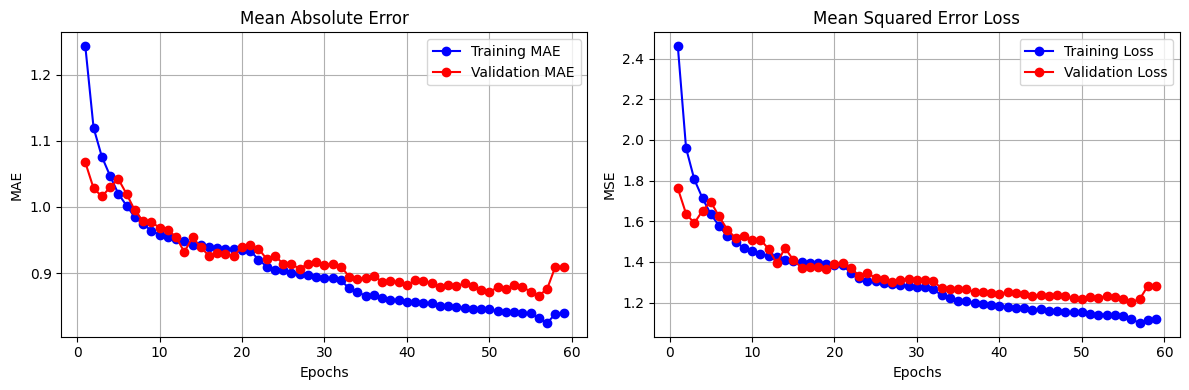

In [ ]:
plot_train_val_metrics()

## Evaluate the model on the test data

In [81]:
from tensorflow import keras
base_path = "/XXX" # Change this to the path where you have stored the data on your Google Drive
class MaskedConv1D(keras.layers.Conv1D):
    def compute_mask(self, inputs, mask=None):
        return mask  # keep the mask for downstream layers

# Load model with custom objects
model = keras.models.load_model(
    base_path + '/deepdta_model_cnn_lstm.keras',
    custom_objects={'MaskedConv1D': MaskedConv1D}
)
with open(base_path + '/training_history_cnn_lstm.pkl', 'rb') as f:
    history_dict = pickle.load(f)

class MockHistory:
    def __init__(self, history_dict):
        self.history = history_dict

history = MockHistory(history_dict)
print("Model and history loaded successfully!")

Model and history loaded successfully!


In [77]:
test_loss, test_mae = evaluate_test_set()

EVALUATING the MODEL ON TEST SET
Test Set - Loss (MSE): 1.2017, MAE: 0.8644

Benchmark comparison:
My model MSE:     1.2017
DeepDTA paper MSE:  ~0.26 (approximate)


### Plot predictions

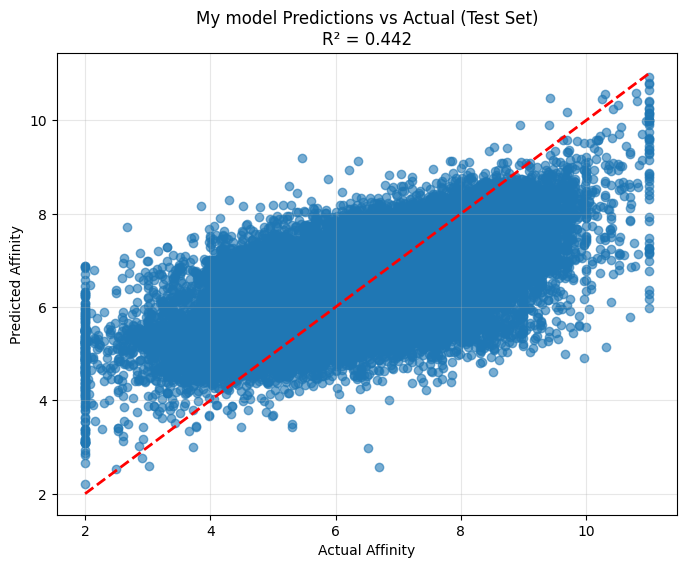

In [ ]:
plot_predictions()

### Print Summary

In [82]:
print_performance_summary()


PERFORMANCE SUMMARY
Training MAE:        nan
Validation MAE:      0.8659
Test MAE:            0.8644
Validation-Test Gap: 0.0015
Training MSE:        nan
Validation MSE:      1.2022
Test MSE:            1.2017
Validation-Test Gap: 0.0005


# Model 4b Hybrid CNN-LSTM, start LR 0.001

In [ ]:
drop_out_1 = 0.3
drop_out_2 = 0.3

dense1_nodes = 512
dense2_nodes = 256
dense3_nodes = 128

### Early stopping and LR rate policys (same as in Model 3 and 4a)

In [ ]:
# Early Stopping Callback
from tensorflow.keras.callbacks import ModelCheckpoint

# Create model directory
model_path = base_path + '/saved_models/cnn_lstm/'
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Save best model (based on validation MAE)
best_checkpoint = ModelCheckpoint(
    filepath=model_path + 'best_model_001.keras',
    monitor='val_mae',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Save every 10th epoch
epoch_checkpoint = ModelCheckpoint(
    filepath=model_path + 'model_001_epoch_{epoch:02d}.keras',
    save_freq=10,  # Save every 10 epochs
    verbose=1
)

# Update callbacks
callbacks = [early_stopping, lr_scheduler, best_checkpoint, epoch_checkpoint]

In [ ]:
model_path = base_path 
if not os.path.exists(model_path):
    os.makedirs(model_path)
model_path

### Saving the model due to recurring crashes

In [ ]:
# Training checkpoints - saves best model + every 10th epoch
from tensorflow.keras.callbacks import ModelCheckpoint

# Save best model (based on validation MAE)
best_checkpoint = ModelCheckpoint(
    filepath=model_path + 'best_model_001.keras',
    monitor='val_mae',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Custom callback for saving every 10th epoch
class EpochSaver(keras.callbacks.Callback):
    def __init__(self, filepath, save_every=10):
        super().__init__()
        self.filepath = filepath
        self.save_every = save_every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_every == 0:
            save_path = self.filepath.format(epoch=epoch + 1)
            self.model.save(save_path)
            print(f"\nSaved model at epoch {epoch + 1}")

# Create epoch saver - saves every 10th epoch
epoch_checkpoint = EpochSaver(
    filepath=model_path + 'model_001_epoch_{epoch:02d}.keras',
    save_every=10
)

# Update callbacks
callbacks = [early_stopping, lr_scheduler, best_checkpoint, epoch_checkpoint]


In [ ]:
# Protein
input_dim_prot = len(prot_vec.get_vocabulary()) # vocabulary size
output_dim = 128 #  taken from DeepDTA paper

# SMILES
input_dim_smi  = len(smi_vec.get_vocabulary())

### Need to adjust padding/masking for LSTM

In [ ]:
import keras

class MaskedConv1D(keras.layers.Conv1D):
    def compute_mask(self, inputs, mask=None):
        return mask  # keep the mask for downstream LSTM

## Build the new model

In [ ]:
def build_cnn_lstm_model():
    """Model 4b: CNN for local patterns + LSTM for sequential context"""

    # PROTEIN BRANCH - CNN then LSTM
    protein_input = keras.Input(shape=(MAX_PROT_LEN_P99,), name="protein_input")
    protein_embedding = keras.layers.Embedding(
        input_dim=input_dim_prot,
        output_dim=output_dim,
        # input_length=MAX_PROT_LEN_P99,
        mask_zero=True,
        name="protein_embedding"
    )(protein_input)

    # CNN layers first - extract local patterns
    protein_conv1 = MaskedConv1D(64, 8, activation='relu', padding='same')(protein_embedding)
    protein_conv2 = MaskedConv1D(96, 8, activation='relu', padding='same')(protein_conv1)

    # LSTM layers second - capture sequence dependencies
    protein_lstm = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=False, dropout=0.2)
    )(protein_conv2)

    # SMILES BRANCH - CNN then LSTM
    smiles_input = keras.Input(shape=(MAX_SMI_LEN,), name="smiles_input")
    smiles_embedding = keras.layers.Embedding(
        input_dim=input_dim_smi,
        output_dim=128,
        # input_length=MAX_SMI_LEN,
        mask_zero=True,
        name="smiles_embedding"
    )(smiles_input)

    # CNN layers first
    smiles_conv1  = MaskedConv1D(64, 4, activation='relu', padding='same')(smiles_embedding)
    smiles_conv2  = MaskedConv1D(96, 4, activation='relu', padding='same')(smiles_conv1)

    # LSTM layers second
    smiles_lstm = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=False, dropout=0.2)
    )(smiles_conv2)

    # COMBINE FEATURES
    combined_features = keras.layers.Concatenate()([protein_lstm, smiles_lstm])

    # DENSE LAYERS
    dense1 = keras.layers.Dense(256, activation='relu')(combined_features)
    dropout1 = keras.layers.Dropout(0.3)(dense1)

    dense2 = keras.layers.Dense(128, activation='relu')(dropout1)
    dropout2 = keras.layers.Dropout(0.3)(dense2)

    # OUTPUT
    output = keras.layers.Dense(1, name="affinity_prediction")(dropout2)

    model = keras.Model(
        inputs=[protein_input, smiles_input],
        outputs=output,
        name="CNN_LSTM_Hybrid_Model"
    )
    return model

print("CNN-LSTM hybrid model defined!")

CNN-LSTM hybrid model defined!


In [ ]:
model = build_cnn_lstm_model()
model.summary()

Model: "CNN_LSTM_Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ protein_input       │ (None, 1388)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_embedding   │ (None, 1388, 128) │      2,944 │ protein_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smiles_embedding    │ (None, 100, 128)  │      6,400 │ smiles_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_conv1d       │ (None, 1388, 64)  │     65,600 │ protein_embeddin… │
│ (MaskedConv1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_conv1d_2     │ (None, 100, 64)   │     32,832 │ smiles_embedding… │
│ (MaskedConv1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_conv1d_1     │ (None, 1388, 96)  │     49,248 │ masked_conv1d[0]… │
│ (MaskedConv1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 1388)      │          0 │ protein_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_conv1d_3     │ (None, 100, 96)   │     24,672 │ masked_conv1d_2[… │
│ (MaskedConv1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 100)       │          0 │ smiles_input[0][… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     82,432 │ masked_conv1d_1[… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     82,432 │ masked_conv1d_3[… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ affinity_prediction │ (None, 1)         │        129 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                 

 Total params: 445,377 (1.70 MB)

 Trainable params: 445,377 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [ ]:
model.compile(
    optimizer='adam',  # higher learning rate
    loss='mse',          # Mean Squared Error for regression
    metrics=['mae']      # Mean Absolute Error for monitoring
)

In [ ]:
batch_size = 64
number_of_epochs = 100

## Train the model

In [ ]:
history = train_the_model()

Start Time:: 21:44:41
Epoch 1/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 2.1407 - mae: 1.1658
Epoch 1: val_mae improved from inf to 1.03261, saving model to /content/drive/MyDrive/DeepLearning UU/DeepLearning Project/protein-compound-affinity//saved_models/cnn_lstm/best_model_001.keras
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 271s 113ms/step - loss: 2.1406 - mae: 1.1658 - val_loss: 1.7018 - val_mae: 1.0326 - learning_rate: 0.0010
Epoch 2/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.6973 - mae: 1.0243
Epoch 2: val_mae improved from 1.03261 to 0.89317, saving model to /content/drive/MyDrive/DeepLearning UU/DeepLearning Project/protein-compound-affinity//saved_models/cnn_lstm/best_model_001.keras
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 269s 112ms/step - loss: 1.6973 - mae: 1.0243 - val_loss: 1.3025 - val_mae: 0.8932 - learning_rate: 0.0010
Epoch 3/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.5180 - mae: 0.9671
Epoch 3: val_mae improved from 0.89317 to 0.86013, savin

## Save the model

In [ ]:
# Save the trained model
print("Saving model...")
model.save(base_path + '/saved_models/deepdta_model_cnn_lstm_001.keras')
print("Model saved successfully!")

Saving model...
Model saved successfully!


In [ ]:
model.save_weights(base_path + '/saved_models/deepdta_cnn_lstm_001_weights.weights.h5')
print("Weights saved successfully!")

Weights saved successfully!


In [ ]:
# Save training history
import pickle
with open(base_path + '/saved_models/training_history_cnn_lstm_001.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## Plot Train & Val metrics

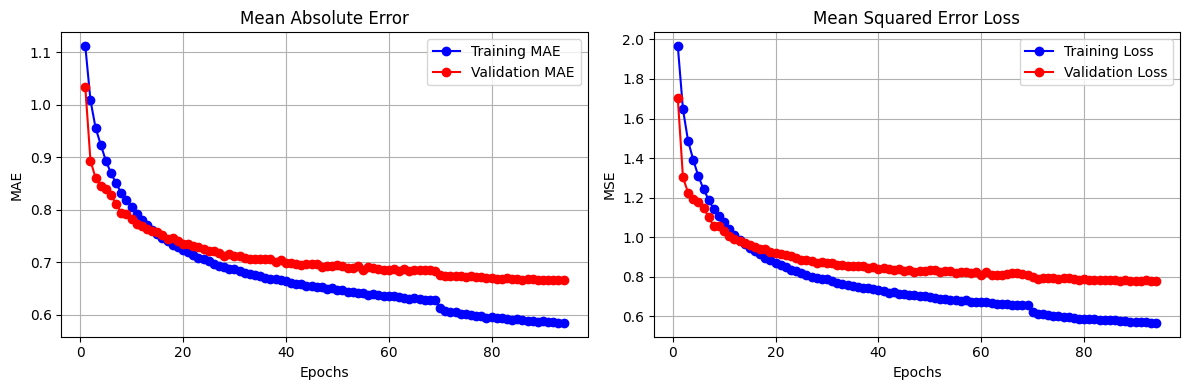

In [ ]:
plot_train_val_metrics()

## Evaluate the model on the test data

In [83]:
from tensorflow import keras
base_path = "/XXX" # Change this to the path where you have stored the data on your Google Drive
class MaskedConv1D(keras.layers.Conv1D):
    def compute_mask(self, inputs, mask=None):
        return mask  # keep the mask for downstream layers

# Load model with custom objects
model = keras.models.load_model(
    base_path + '/deepdta_model_cnn_lstm_001.keras',
    custom_objects={'MaskedConv1D': MaskedConv1D}
)
with open(base_path + '/training_history_cnn_lstm_001.pkl', 'rb') as f:
    history_dict = pickle.load(f)

class MockHistory:
    def __init__(self, history_dict):
        self.history = history_dict

history = MockHistory(history_dict)
print("Model and history loaded successfully!")

Model and history loaded successfully!


In [85]:
test_loss, test_mae = evaluate_test_set()

EVALUATING the MODEL ON TEST SET
Test Set - Loss (MSE): 0.7719, MAE: 0.6606

Benchmark comparison:
My model MSE:     0.7719
DeepDTA paper MSE:  ~0.26 (approximate)


### Plot predictions

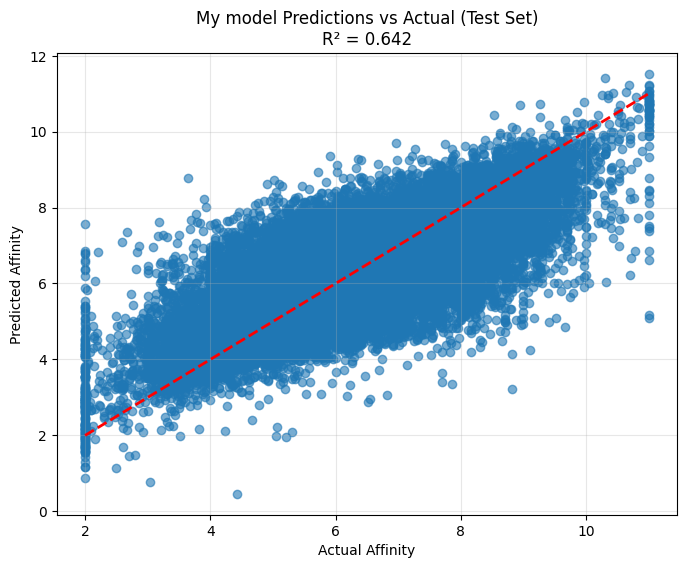

In [ ]:
plot_predictions()

### Print Summary

In [86]:
print_performance_summary()


PERFORMANCE SUMMARY
Training MAE:        0.5848
Validation MAE:      0.6651
Test MAE:            0.6606
Validation-Test Gap: 0.0044
Training MSE:        0.5687
Validation MSE:      0.7770
Test MSE:            0.7719
Validation-Test Gap: 0.0051


# Test

## Retreive a model (pure CNN)

In [89]:
# Load saved model and training history
import keras
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Load the model and history
model = keras.models.load_model(base_path + '/deepdta_model.keras')
with open(base_path + '/training_history.pkl', 'rb') as f:
    history_dict = pickle.load(f)

class MockHistory:
    def __init__(self, history_dict):
        self.history = history_dict

history = MockHistory(history_dict)
print("Model and history loaded successfully!")

Model and history loaded successfully!


## Retreive CNN + LSTM model

In [ ]:
!ls "/content/drive/MyDrive/XXX/saved_models_cnn_lstm/"

cnn_lstm_check_points			 deepdta_model_cnn_lstm.keras
deepdta_cnn_lstm_001_weights.weights.h5  training_history_cnn_lstm_001.pkl
deepdta_cnn_lstm_weights.weights.h5	 training_history_cnn_lstm.pkl
deepdta_model_cnn_lstm_001.keras


In [52]:
from tensorflow import keras

class MaskedConv1D(keras.layers.Conv1D):
    def compute_mask(self, inputs, mask=None):
        return mask  # keep the mask for downstream layers

In [53]:
print("Loading model...")
model = keras.models.load_model(
    base_path + '/deepdta_model_cnn_lstm_001.keras',
    custom_objects={"MaskedConv1D": MaskedConv1D}
)
print("Model loaded successfully!")

Loading model...
Model loaded successfully!


In [56]:
test_mae = evaluate_test_set()

EVALUATING the MODEL ON TEST SET
Test Set - Loss (MSE): 0.7719, MAE: 0.6606

Benchmark comparison:
My model MSE:     0.7719
DeepDTA paper MSE:  ~0.26 (approximate)
